In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime
from math import *
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [16,9]

In [2]:
train_data = pd.read_csv('nyc-taxi-trip-duration/train.csv')
test_data = pd.read_csv('nyc-taxi-trip-duration/test.csv')
#osmr_1 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv', 
                     #usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
#osmr_2 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv',
                     #usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])

In [3]:
test_data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [4]:
test_data.shape

(625134, 9)

We first add new features that seems to be intersting in our modelisation problem. We define a direction features based on initial and final destination using geospatial formula. 

In [5]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

jfk_coord = pd.DataFrame(np.array([[-73.778889,40.639722]]),columns=['lon','lat'])
la_guardia_coord = pd.DataFrame(np.array([[-73.872611,40.77725]]),columns=['lon','lat'])


In [6]:
test_data.loc[:, 'direction'] = bearing_array(test_data['pickup_latitude'].values, 
                                          test_data['pickup_longitude'].values, 
                                          test_data['dropoff_latitude'].values, 
                                          test_data['dropoff_longitude'].values)
test_data.loc[:, 'distance_haversine'] = haversine_array(test_data['pickup_latitude'].values, 
                                                     test_data['pickup_longitude'].values, 
                                                     test_data['dropoff_latitude'].values, 
                                                     test_data['dropoff_longitude'].values)
test_data.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test_data['pickup_latitude'].values, 
                                                                    test_data['pickup_longitude'].values, 
                                                                    test_data['dropoff_latitude'].values, 
                                                                    test_data['dropoff_longitude'].values)

test_data['pickup_datetime'] = pd.to_datetime(test_data['pickup_datetime'])
#test_data['dropoff_datetime'] = pd.to_datetime(test_data['dropoff_datetime'])
test_data['pickup_year'] = test_data['pickup_datetime'].dt.year
test_data['pickup_month'] = test_data['pickup_datetime'].dt.month
test_data['pickup_day'] = test_data['pickup_datetime'].dt.day
test_data['pickup_hour'] = test_data['pickup_datetime'].dt.hour
test_data['pickup_minute'] = test_data['pickup_datetime'].dt.minute
test_data['pickup_weekday'] = test_data['pickup_datetime'].dt.weekday

test_data['jfk_dist_pick'] = haversine_array(test_data['pickup_latitude'].values, 
                                              test_data['pickup_longitude'].values,
                                             jfk_coord['lat'].values, jfk_coord['lon'].values)
test_data['jfk_dist_drop'] = haversine_array(test_data['dropoff_latitude'].values, 
                                              test_data['dropoff_longitude'].values,
                                             jfk_coord['lat'].values, jfk_coord['lon'].values)
test_data['lg_dist_pick'] = haversine_array(test_data['pickup_latitude'].values, 
                                              test_data['pickup_longitude'].values,
                                             la_guardia_coord['lat'].values, la_guardia_coord['lon'].values)
test_data['lg_dist_drop'] = haversine_array(test_data['dropoff_latitude'].values, 
                                              test_data['dropoff_longitude'].values,
                                             la_guardia_coord['lat'].values, la_guardia_coord['lon'].values)
test_data['jfk_trip'] = (test_data['jfk_dist_pick'] < 2e3) | (test_data['jfk_dist_drop'] < 2e3)
test_data['jfk_trip'].astype(int)
test_data['lg_trip'] = (test_data['lg_dist_pick'] < 2e3) | (test_data['lg_dist_drop'] < 2e3)
test_data['lg_trip'].astype(int)
test_data['work'] = (test_data['pickup_hour'].isin(range(8,18))) & (test_data['pickup_weekday'].isin([0,1,2,3,4]))
test_data['work'].astype(int)
test_data['date'] = test_data['pickup_datetime'].dt.date

#test_data['speed'] = test_data['distance_haversine']/(test_data['trip_duration']/3600)

In [7]:
np.sum(test_data.isna())
print(test_data.shape)

(625134, 26)


In [8]:
test_data.shape

(625134, 26)

In [9]:
"""train_data = train_data[train_data['trip_duration'] < (22*3600)]
#isclose = isclose(train_data['distance_haversine'].values,0)
train_data = train_data[(train_data['distance_haversine']>0) | (train_data['trip_duration']<60)] 
train_data = train_data[(train_data['jfk_dist_pick'] < 3e5) & (train_data['jfk_dist_drop'] < 3e5)]
train_data = train_data[train_data['trip_duration'] > 10]
train_data = train_data[train_data['speed'] < 100]
"""

"train_data = train_data[train_data['trip_duration'] < (22*3600)]\n#isclose = isclose(train_data['distance_haversine'].values,0)\ntrain_data = train_data[(train_data['distance_haversine']>0) | (train_data['trip_duration']<60)] \ntrain_data = train_data[(train_data['jfk_dist_pick'] < 3e5) & (train_data['jfk_dist_drop'] < 3e5)]\ntrain_data = train_data[train_data['trip_duration'] > 10]\ntrain_data = train_data[train_data['speed'] < 100]\n"

In [10]:
weather = pd.read_csv('weather/weather_data_nyc_centralpark_2016.csv')

In [11]:
weather.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0
3,4-1-2016,36,14,25.0,0.00,0.0,0
4,5-1-2016,29,11,20.0,0.00,0.0,0


In [12]:
weather['date'] = weather['date'].apply(lambda x : datetime.datetime.strptime(x, '%d-%m-%Y'))
def Tto(x):
    if x == 'T':
        return(0.01)
    else:
        return(x)
    
weather['rain'] = weather['precipitation'].apply(lambda x : Tto(x)).astype(float)
weather['s_fall'] = weather['snow fall'].apply(lambda x : Tto(x)).astype(float)
weather['s_depth'] = weather['snow depth'].apply(lambda x : Tto(x)).astype(float)
weather['all_precip'] = (weather['rain'].values + weather['s_fall'].values)
weather['has_snow'] = ((weather['s_fall'] > 0) | (weather['s_depth'] >0))
weather['has_rain'] = (weather['rain'] > 0) 

weather.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,rain,s_fall,s_depth,all_precip,has_snow,has_rain
0,2016-01-01,42,34,38.0,0.00,0.0,0,0.0,0.0,0.0,0.0,False,False
1,2016-01-02,40,32,36.0,0.00,0.0,0,0.0,0.0,0.0,0.0,False,False
2,2016-01-03,45,35,40.0,0.00,0.0,0,0.0,0.0,0.0,0.0,False,False
3,2016-01-04,36,14,25.0,0.00,0.0,0,0.0,0.0,0.0,0.0,False,False
4,2016-01-05,29,11,20.0,0.00,0.0,0,0.0,0.0,0.0,0.0,False,False


In [13]:
weather['date'] = pd.to_datetime(weather['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

test_data = pd.merge(test_data, weather[['date','rain', 's_fall', 'all_precip', 'has_snow', 'has_rain','s_depth',
                                             'minimum temperature','maximum temperature']], on = 'date', how = 'left')




In [14]:
print(test_data.shape)
np.sum(test_data.isna())

(625134, 34)


id                          0
vendor_id                   0
pickup_datetime             0
passenger_count             0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
store_and_fwd_flag          0
direction                   0
distance_haversine          0
distance_dummy_manhattan    0
pickup_year                 0
pickup_month                0
pickup_day                  0
pickup_hour                 0
pickup_minute               0
pickup_weekday              0
jfk_dist_pick               0
jfk_dist_drop               0
lg_dist_pick                0
lg_dist_drop                0
jfk_trip                    0
lg_trip                     0
work                        0
date                        0
rain                        0
s_fall                      0
all_precip                  0
has_snow                    0
has_rain                    0
s_depth                     0
minimum temperature         0
maximum te

In [15]:
osmr_1 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv',
                    usecols=['id', 'total_distance', 'total_travel_time','number_of_steps',
                              'step_direction', 'step_maneuvers'])
osmr_2 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv',
                    usecols=['id', 'total_distance', 'total_travel_time','number_of_steps',
                              'step_direction', 'step_maneuvers'])
osmr_3 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                     usecols=['id', 'total_distance', 'total_travel_time','number_of_steps',
                              'step_direction', 'step_maneuvers'])

In [16]:
osmr_3.shape

(625134, 6)

In [17]:
temp = osmr_3
temp['fastest_speed'] = (temp['total_distance']/(temp['total_travel_time']+1)*3.6)
temp['left_turns'] = temp['step_direction'].str.count('left')
temp['right_turns'] = temp['step_direction'].str.count('right')
temp['turns'] = temp['step_maneuvers'].str.count('turn')
temp = temp.drop(columns=['step_direction','step_maneuvers'])

np.sum(temp.isna())

id                   0
total_distance       0
total_travel_time    0
number_of_steps      0
fastest_speed        0
left_turns           0
right_turns          0
turns                0
dtype: int64

In [18]:
temp['total_travel_time']

0          200.2
1          141.5
2          324.6
3           84.2
4          294.7
           ...  
625129     417.4
625130     890.4
625131     896.6
625132    1056.4
625133       0.0
Name: total_travel_time, Length: 625134, dtype: float64

In [19]:
test_data = pd.merge(test_data, temp, on = 'id', how = 'left')




In [20]:
#print(fastest_routes['id']=='id3505355')

In [21]:
np.sum(test_data.isna())

id                          0
vendor_id                   0
pickup_datetime             0
passenger_count             0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
store_and_fwd_flag          0
direction                   0
distance_haversine          0
distance_dummy_manhattan    0
pickup_year                 0
pickup_month                0
pickup_day                  0
pickup_hour                 0
pickup_minute               0
pickup_weekday              0
jfk_dist_pick               0
jfk_dist_drop               0
lg_dist_pick                0
lg_dist_drop                0
jfk_trip                    0
lg_trip                     0
work                        0
date                        0
rain                        0
s_fall                      0
all_precip                  0
has_snow                    0
has_rain                    0
s_depth                     0
minimum temperature         0
maximum te

In [22]:
np.sum(test_data.isna())
print(test_data.shape)

(625134, 41)


In [23]:
def blizzardTest(x):
    return(not((x.strftime('%Y-%m-%d')< '2016-01-22' ) | ( x.strftime('%Y-%m-%d') > '2016-01-29' )))

test_data['blizzard'] = test_data['date'].apply(lambda x : blizzardTest(x)).astype(int)


test_data['passenger_count'] = test_data['passenger_count'].astype(int)
test_data['vendor_id'] = test_data['vendor_id'].astype(int)
#test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].astype(int)
test_data['jfk_trip'] = test_data['jfk_trip'].astype(int)
test_data['lg_trip'] = test_data['lg_trip'].astype(int)
test_data['work'] = test_data['work'].astype(int)
test_data['has_snow'] = test_data['has_snow'].astype(int)
test_data['has_rain'] = test_data['has_rain'].astype(int)

test_data = test_data.drop(columns=['pickup_year','pickup_minute'])





In [24]:
"""foo1 = train_data.drop(columns=['id','pickup_datetime','dropoff_datetime','jfk_dist_pick','jfk_dist_drop',
                        'lg_dist_pick','lg_dist_drop','date'])"""

"foo1 = train_data.drop(columns=['id','pickup_datetime','dropoff_datetime','jfk_dist_pick','jfk_dist_drop',\n                        'lg_dist_pick','lg_dist_drop','date'])"

In [25]:
test_data.shape

(625134, 40)

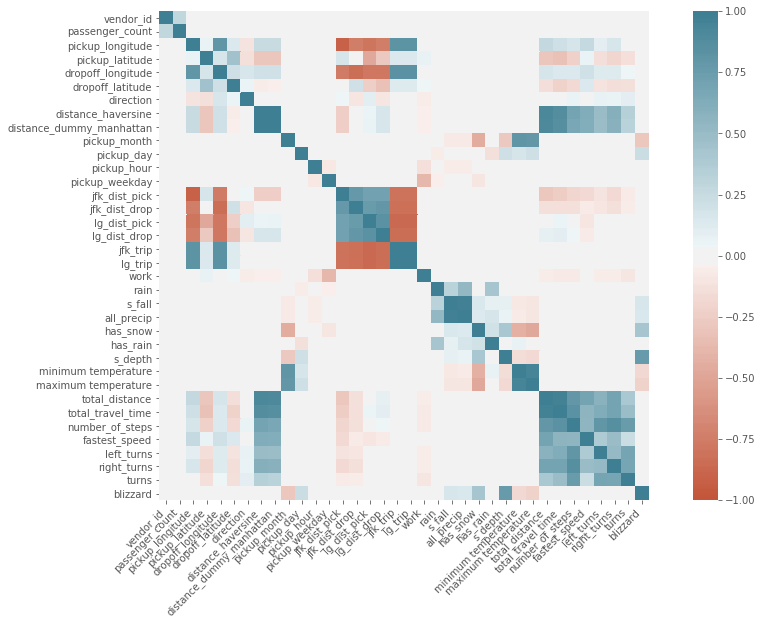

In [26]:
import seaborn as sns
corr = test_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [27]:
"""foo = train_data.drop(columns=['store_and_fwd_flag', 'pickup_hour', 'rain', 's_fall', 'all_precip',
         'has_rain', 's_depth', 'minimum temperature', 'maximum temperature',
         'pickup_weekday', 'right_turns', 'turns'])

corr = foo.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);"""

"foo = train_data.drop(columns=['store_and_fwd_flag', 'pickup_hour', 'rain', 's_fall', 'all_precip',\n         'has_rain', 's_depth', 'minimum temperature', 'maximum temperature',\n         'pickup_weekday', 'right_turns', 'turns'])\n\ncorr = foo.corr()\nax = sns.heatmap(\n    corr, \n    vmin=-1, vmax=1, center=0,\n    cmap=sns.diverging_palette(20, 220, n=200),\n    square=True\n)\nax.set_xticklabels(\n    ax.get_xticklabels(),\n    rotation=45,\n    horizontalalignment='right'\n);"

In [28]:
data = test_data.drop(columns = ['id','pickup_datetime',
                            'store_and_fwd_flag','date'])



In [29]:
data.to_csv('preprocessed_test_data.csv')

In [30]:
test_data.dtypes

id                                  object
vendor_id                            int64
pickup_datetime             datetime64[ns]
passenger_count                      int64
pickup_longitude                   float64
pickup_latitude                    float64
dropoff_longitude                  float64
dropoff_latitude                   float64
store_and_fwd_flag                  object
direction                          float64
distance_haversine                 float64
distance_dummy_manhattan           float64
pickup_month                         int64
pickup_day                           int64
pickup_hour                          int64
pickup_weekday                       int64
jfk_dist_pick                      float64
jfk_dist_drop                      float64
lg_dist_pick                       float64
lg_dist_drop                       float64
jfk_trip                             int64
lg_trip                              int64
work                                 int64
date       

In [31]:
test_data.shape

(625134, 40)